In [30]:
mkdir images

mkdir: cannot create directory ‘images’: File exists


In [0]:
mv images.zip images/

In [32]:
cd images

/content/images


In [33]:
!unzip images.zip

Archive:  images.zip
  inflating: 0.jpeg                  
  inflating: 1.jpeg                  
  inflating: 10.jpeg                 
  inflating: 100.jpeg                
  inflating: 101.jpeg                
  inflating: 102.jpeg                
  inflating: 103.jpeg                
  inflating: 104.jpeg                
  inflating: 105.jpeg                
  inflating: 106.jpeg                
  inflating: 107.jpeg                
  inflating: 108.jpeg                
  inflating: 109.jpeg                
  inflating: 11.jpeg                 
  inflating: 110.jpeg                
  inflating: 111.jpeg                
  inflating: 112.jpeg                
  inflating: 113.jpeg                
  inflating: 114.jpeg                
  inflating: 115.jpeg                
  inflating: 116.jpeg                
  inflating: 117.jpeg                
  inflating: 118.jpeg                
  inflating: 119.jpeg                
  inflating: 12.jpeg                 
  inflating: 120.jpeg        

In [0]:
rm images.zip

In [35]:
cd ..

/content


In [0]:
import os 
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from PIL import Image

import random
from scipy.spatial import distance

In [0]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
def load_image(path):
  img = image.load_img(path, target_size=model.input_shape[1:3])
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


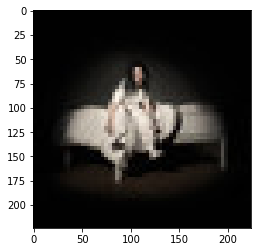

In [40]:
img, x = load_image("images/0.jpeg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [41]:
predictions = model.predict(x)
for _, pred, prob in decode_predictions(predictions)[0]:
  print("predicted %s with a probabilty of %0.3f" % (pred, prob))

predicted castle with a probabilty of 0.156
predicted church with a probabilty of 0.128
predicted beacon with a probabilty of 0.105
predicted bell_cote with a probabilty of 0.079
predicted monastery with a probabilty of 0.062


In [42]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

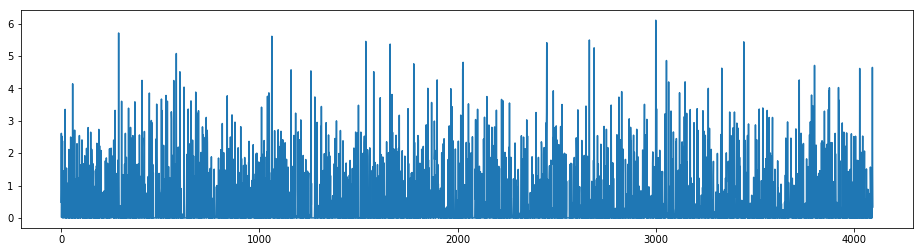

In [43]:
img,x = load_image("images/0.jpeg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [44]:
path = "images"
images = []

for img in os.listdir(path):
  img_path = os.path.join(path,img)
  images.append(img_path)

print(images)

['images/547.jpeg', 'images/589.jpeg', 'images/235.jpeg', 'images/330.jpeg', 'images/559.jpeg', 'images/356.jpeg', 'images/183.jpeg', 'images/62.jpeg', 'images/632.jpeg', 'images/484.jpeg', 'images/441.jpeg', 'images/58.jpeg', 'images/469.jpeg', 'images/192.jpeg', 'images/249.jpeg', 'images/334.jpeg', 'images/618.jpeg', 'images/601.jpeg', 'images/456.jpeg', 'images/133.jpeg', 'images/161.jpeg', 'images/103.jpeg', 'images/540.jpeg', 'images/499.jpeg', 'images/114.jpeg', 'images/421.jpeg', 'images/333.jpeg', 'images/93.jpeg', 'images/89.jpeg', 'images/414.jpeg', 'images/429.jpeg', 'images/261.jpeg', 'images/107.jpeg', 'images/313.jpeg', 'images/56.jpeg', 'images/97.jpeg', 'images/622.jpeg', 'images/432.jpeg', 'images/50.jpeg', 'images/33.jpeg', 'images/316.jpeg', 'images/541.jpeg', 'images/198.jpeg', 'images/47.jpeg', 'images/63.jpeg', 'images/263.jpeg', 'images/71.jpeg', 'images/463.jpeg', 'images/627.jpeg', 'images/573.jpeg', 'images/543.jpeg', 'images/418.jpeg', 'images/162.jpeg', 'im

In [0]:
features = []

for img in images:
  img,x = load_image(img)
  feat = feat_extractor.predict(x)[0]
  features.append(feat)

In [46]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
pca_features = pca.transform(features)

In [0]:
def select_image(img_bank):
  
  query_image_idx = int(len(img_bank) * random.random())
  
  img = image.load_img(img_bank[query_image_idx])
  plt.imshow(img)
  
  return query_image_idx

In [0]:
def find_similar(idx, img_bank):
  
  similar_idx = [distance.cosine(pca_features[idx], feat) for feat in pca_features]
  idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]
  
  thumbs = []
  for i in idx_closest:
    img = image.load_img(img_bank[i])
    img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)
  
  concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)


  plt.figure(figsize = (16,12))
  plt.imshow(concat_image)

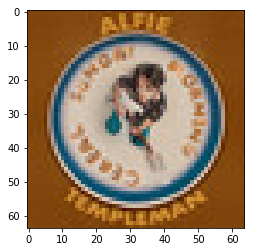

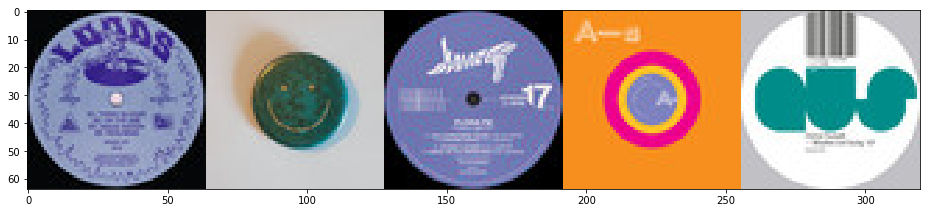

In [58]:
query = select_image(images)
find_similar(query, images)